In [11]:
from transformers import AutoTokenizer, AutoModel
# load model and tokenizer # reference: https://github.com/allenai/specter
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

In [12]:
import json 
with open('pubmed_articles.json') as f:
    papers = json.load(f)

In [13]:
# preprocess the input
i=0
for paper in papers.values(): 
    data = paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"] 
    inputs = tokenizer(data, padding=True, truncation=True, return_tensors="pt", max_length=512)
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings = result.last_hidden_state[:, 0, :].detach().numpy()
    embeddings_list[i:] = embeddings
    i+=1

In [14]:
from sklearn import decomposition
import pandas as pd
import numpy as np
embeddings_arr = np.array(embeddings_list)
pca = decomposition.PCA(n_components=3)
embeddings_arr_pca = pd.DataFrame(
    pca.fit_transform(embeddings_arr),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_arr_pca["query"] = [paper["query"] for paper in papers.values()]

In [15]:
embeddings_arr_pca.head()

,PC0,PC1,PC2,query
0,-4.422033,-3.780090,-0.605965,Alzheimer
1,-4.509223,5.234956,-0.582491,Alzheimer
2,-2.664780,-4.722886,2.113799,Alzheimer
3,-6.865324,1.841079,0.896379,Alzheimer
4,-0.133805,-5.919688,-5.722940,Alzheimer


Plot 2D scatter plots for PC0 vs PC1, PC0 vs PC2, and PC1 vs PC2; color code these by the search query used (Alzheimers vs cancer). (3 points) 

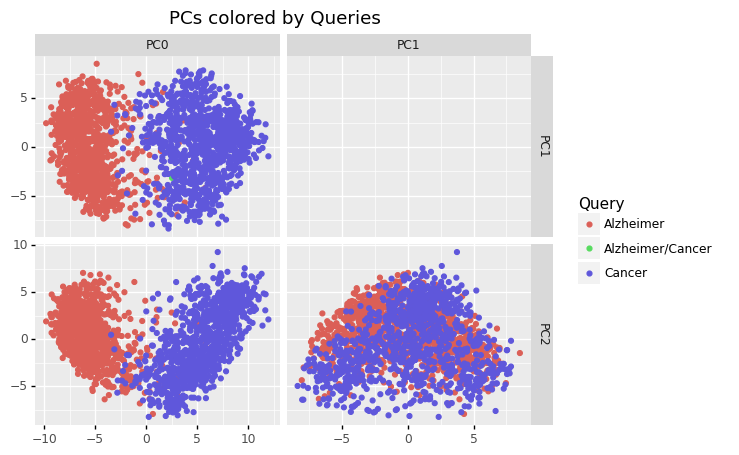

<ggplot: (171031846340)>

In [16]:
import plotnine as p9
# Create a list of PCA lables
pca_labels = ['PC0', 'PC1', 'PC2']
# Plot the paper data, facet y=PCY, x=PCX
plot_data = []
for pcx in pca_labels:
    for pcy in pca_labels:
        if pcx < pcy:
            plot_data.append(pd.DataFrame(
                {
                    'Query': embeddings_arr_pca['query'],
                    'PCX': pcx, 
                    'PCY': pcy, 
                    'X': embeddings_arr_pca[pcx],
                    'Y': embeddings_arr_pca[pcy]
                }
            ))
(
    p9.ggplot(pd.concat(plot_data))
      + p9.geom_point(p9.aes(x="X", y="Y", color="Query"))
      + p9.facet_grid("PCY~PCX",scales="free")
      + p9.labs(x="", y="")
      + p9.labels.ggtitle("PCs colored by Queries")
)

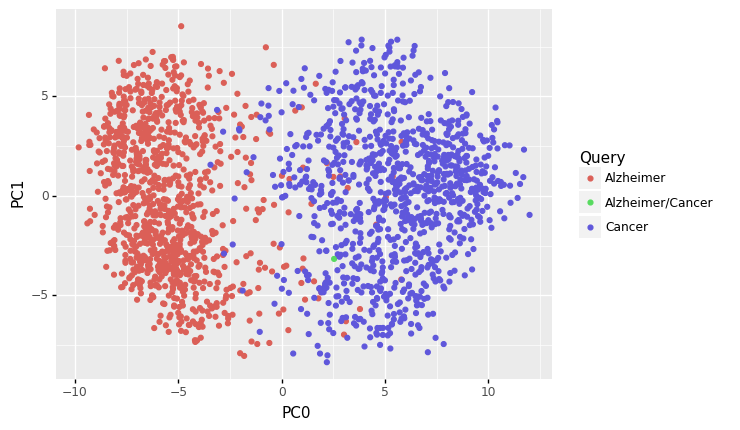

<ggplot: (171035610868)>

In [18]:
# Visualize PC0 vs PC1
(
    p9.ggplot(pd.DataFrame({
      'Query': embeddings_arr_pca['query'],
      'X': embeddings_arr_pca['PC0'],
      'Y': embeddings_arr_pca['PC1']
    }))
    + p9.geom_point(p9.aes(x="X", y="Y", color="Query"))
    + p9.labs(x="PC0", y="PC1")
)

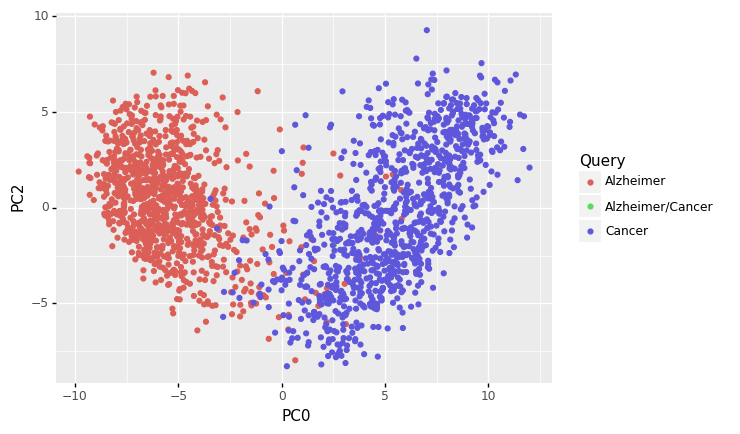

<ggplot: (171035283321)>

In [19]:
# Visualize PC0 vs PC2 
(
    p9.ggplot(pd.DataFrame({
      'Query': embeddings_arr_pca['query'],
      'X': embeddings_arr_pca['PC0'],
      'Y': embeddings_arr_pca['PC2']
    }))
    + p9.geom_point(p9.aes(x="X", y="Y", color="Query"))
    + p9.labs(x="PC0", y="PC2")
)

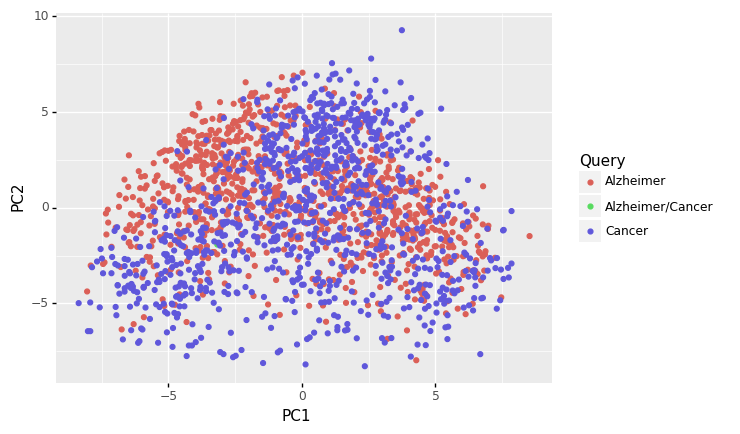

<ggplot: (171035356823)>

In [20]:
# Visualize PC1 vs PC2
(
    p9.ggplot(pd.DataFrame({
      'Query': embeddings_arr_pca['query'],
      'X': embeddings_arr_pca['PC1'],
      'Y': embeddings_arr_pca['PC2']
    }))
    + p9.geom_point(p9.aes(x="X", y="Y", color="Query"))
    + p9.labs(x="PC1", y="PC2")
)

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
target_name = embeddings_arr_pca["query"]
lda = LDA(n_components=2)
embeddings_arr_lda = pd.DataFrame(
    lda.fit_transform(embeddings_arr, target_name),
    columns=['LD0', 'LD1']
)
embeddings_arr_lda["query"] = [paper["query"] for paper in papers.values()]

In [31]:
embeddings_arr_lda.head()

,LD0,LD1,query
0,-4.217578,-0.231187,Alzheimer
1,-4.625509,1.308359,Alzheimer
2,-4.908934,1.565124,Alzheimer
3,-4.158730,0.704640,Alzheimer
4,-2.137135,-0.239542,Alzheimer


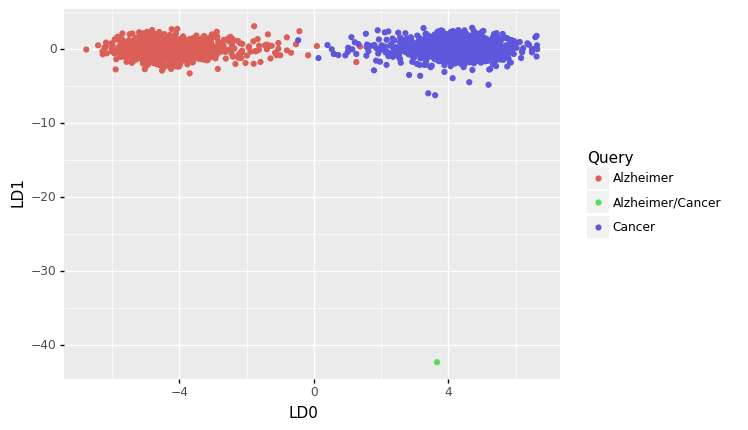

<ggplot: (171035526000)>

In [32]:
(
    p9.ggplot(pd.DataFrame({
      'Query': embeddings_arr_lda['query'],
      'X': embeddings_arr_lda['LD0'],
      'Y': embeddings_arr_lda['LD1']
    }))
    + p9.geom_point(p9.aes(x="X", y="Y", color="Query"))
    + p9.labs(x="LD0", y="LD1")
)